# Pokemon Data Extraction

Extract Pokemon Data from IPhone6 Screenshots using the Tesseract OCR library

## Import notebook that extracts game data

In [1]:
from notebook_loader import NotebookFinder
import sys
sys.meta_path.append(NotebookFinder())
import pokemon_data

importing Jupyter notebook from pokemon_data.ipynb


/Users/chiraag/anaconda/lib/python2.7/site-packages/openpyxl/workbook/names/named_range.py:124: UserWarning: Discarded range with reserved name
  warnings.warn("Discarded range with reserved name")


## OCR for data extraction
Setup Libraries

In [2]:
from tesserocr import PyTessBaseAPI
from PIL import Image
from io import BytesIO
from IPython import display

api = PyTessBaseAPI()
filename = 'test_data/vap.png'

Open current image and create a new pokemon

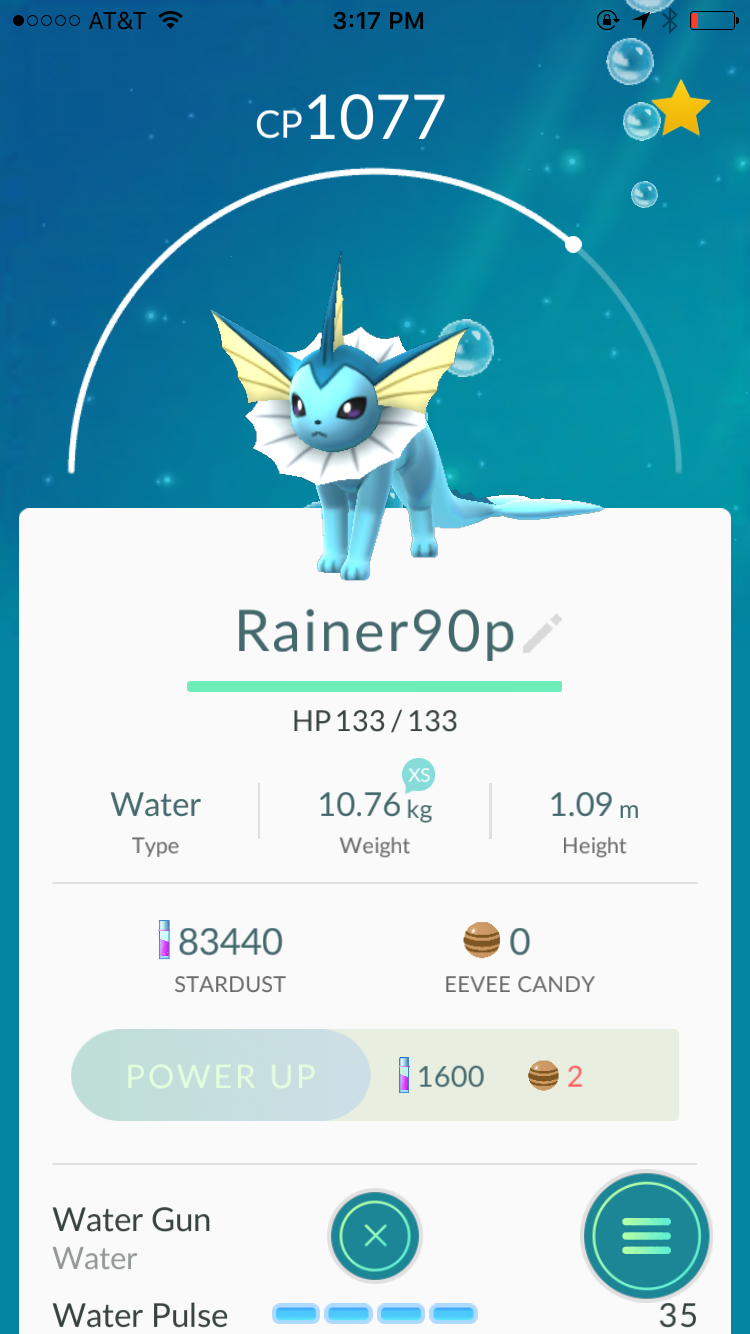

In [3]:
im = Image.open(filename)
pokemon = pokemon_data.Pokemon()

def display_image(im, width=100):
    b = BytesIO()
    im.save(b, format='png')
    display.display(display.Image(data=b.getvalue(), width=width))
    
display_image(im)

Define boxes for extracting strings from the image 

In [4]:
import re
non_decimal = re.compile(r'[^\d.]+')

def extract_string(im, box, extract=True):
    cim = im.crop(box); 
    if extract:
        api.SetImage(cim)
        text = api.GetUTF8Text()
        return text.strip()
    else:
        display_image(cim)
        return ''
    
box = {
    'cp': (200,60,500,160),
    'name': (100,580,700,680),
    'hp': (200,700,550,740),
    'ptype': (20,780,320,830),
    'family': (380,960,650,1010),
    'powerup_dust': (410,1050,500,1100),
    'evolve': (100,1160,340,1210), 
    'evolve_candy': (400,1160,640,1210)     
}

def extract_strings(im, box):
    strings = {}
    strings['cp'] = int(non_decimal.sub('', extract_string(im, box['cp'])[2:]))
    strings['name'] = extract_string(im, box['name'])
    strings['hp'] = int(extract_string(im, box['hp']).split('/')[-1])
    strings['ptype'] = map(str.strip, str(extract_string(im, box['ptype'])).split('/'))
    strings['family'] = extract_string(im, box['family']).split(' ')[0].capitalize()
    strings['powerup_dust'] = int(extract_string(im, box['powerup_dust']))
    strings['evolve_candy'] = 0
    if extract_string(im, box['evolve']) == 'EVOLVE':
        strings['evolve_candy'] = int(non_decimal.sub('', extract_string(im, box['evolve_candy'])))
    return strings

im_ocr = extract_strings(im, box)

print im_ocr

{'name': u'Rainer90p', 'family': u'Eevee', 'powerup_dust': 1600, 'hp': 133, 'ptype': ['Water'], 'evolve_candy': 0, 'cp': 1077}


In [5]:
pokemon.name = im_ocr['name']
pokemon.cp = im_ocr['cp']
pokemon.hp = im_ocr['hp']
pokemon.powerup_dust = im_ocr['powerup_dust']

def match_candy(candy, evolutions):
    if candy == 0 and evolutions.values() == []:
        return True
    elif candy in evolutions.values():
        return True
    else:
        return False

def get_species(strings, species):
    if strings['name'] in species:
        return strings['name']
    else:
        candidates = [ sp for sp in species if species[sp].family == strings['family']]
        candidates = [ sp for sp in candidates if match_candy(strings['evolve_candy'], species[sp].evolutions)]
        candidates = [ sp for sp in candidates if strings['ptype'] ==  species[sp].ptypes]
        if len(candidates) == 1:
            return candidates[0]
        else:
            print candidates
            return None
get_species(im_ocr, pokemon_data.species)

u'Vaporeon'

## Use OpenCV for Arc Position Extraction 
Setup Libraries

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Get rough estimate for arc center and manually refine

In [7]:
image = cv2.imread(filename)
output = image
gray = cv2.equalizeHist(cv2.cvtColor(output, cv2.COLOR_BGR2GRAY))

def display_cv(im, color=True, width=100):
    cv_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB if color else cv2.COLOR_GRAY2RGB)
    b = BytesIO()
    Image.fromarray(cv_rgb).save(b, 'png')
    display.display(display.Image(data=b.getvalue(), width=width))
    
def get_circle_guess(im):
    output = im[100:500, :]
    gray = cv2.equalizeHist(cv2.cvtColor(output, cv2.COLOR_BGR2GRAY))
    
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 3, 100, param1=200, minRadius=295, maxRadius=310)
    # ensure at least some circles were found
    if circles is not None:
        # convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circles[0, :]).astype("int")

        # loop over the (x, y) coordinates and radius of the circles
        for (x, y, r) in circles:
            print '(%g, %g): %g' % (x,y,r)
            cv2.circle(output, (x,y), r, (0, 0, 0), 2)
            
    display_cv(gray, False, width=image.shape[1])
    display_cv(output, width=image.shape[1])

# Values obtained after manual tweaking of the output from the last function 
x, y, r = (375, 472, 303)
#cv2.circle(output, (x,y), r, (0, 0, 0), 1)
#cv2.line(output, (x-r, y), (x+r,y), (255, 0, 0), 1)
#cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 0, 255), -1)



Find the arc end by finding the position of the filled arc end circle

/Users/chiraag/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


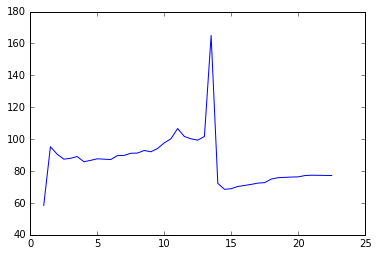

In [10]:
def get_level_pos(poke_level, trainer_level, cpm):
    angle_deg = 202.037116*(cpm[(poke_level-1)*2] - cpm[0])/cpm[(trainer_level-1)*2]
    return angle_deg * np.pi / 180.0

def angle_to_xy(angle, center, r):
    xl = int(np.round(center[0]-r*np.cos(angle)))
    yl = int(np.round(center[1]-r*np.sin(angle)))
    return xl, yl

trainer_level = 21
def extract_level(im_gray, trainer_level, center, r, r_arcend=9):
    x, y = center
    levels = np.arange(1, trainer_level+2, 0.5)
    mask = np.zeros((2*r_arcend,2*r_arcend), np.uint8)
    cv2.circle(mask,(r_arcend,r_arcend),r_arcend,1,thickness=-1)
    
    white = np.zeros(levels.shape)
    for i, poke_level in enumerate(levels):
        angle_rad = get_level_pos(poke_level, trainer_level, pokemon_data.cpm_inter)
        xl, yl = angle_to_xy(angle_rad, (x,y), r)
        masked_arcend = mask*im_gray[yl-r_arcend:yl+r_arcend, xl-r_arcend:xl+r_arcend]
        white[i] = np.average(masked_arcend)
        # display_cv(masked_arcend, False, width=masked_arcend.shape[1])
    plt.plot(levels, white)

    level_index = 0
    for i in range(1,white.shape[0]-1):
        if (white[i-1] < white[i]) and (white[i] > white[i+1]) and (white[i] > np.max(white)*0.8):
            level_index = i
    return level_index, levels[level_index]

level_index, level = extract_level(gray, 21, (x,y), r)
pokemon.level = level

Annotate level and arc position on the pokemon card for debug

/Users/chiraag/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


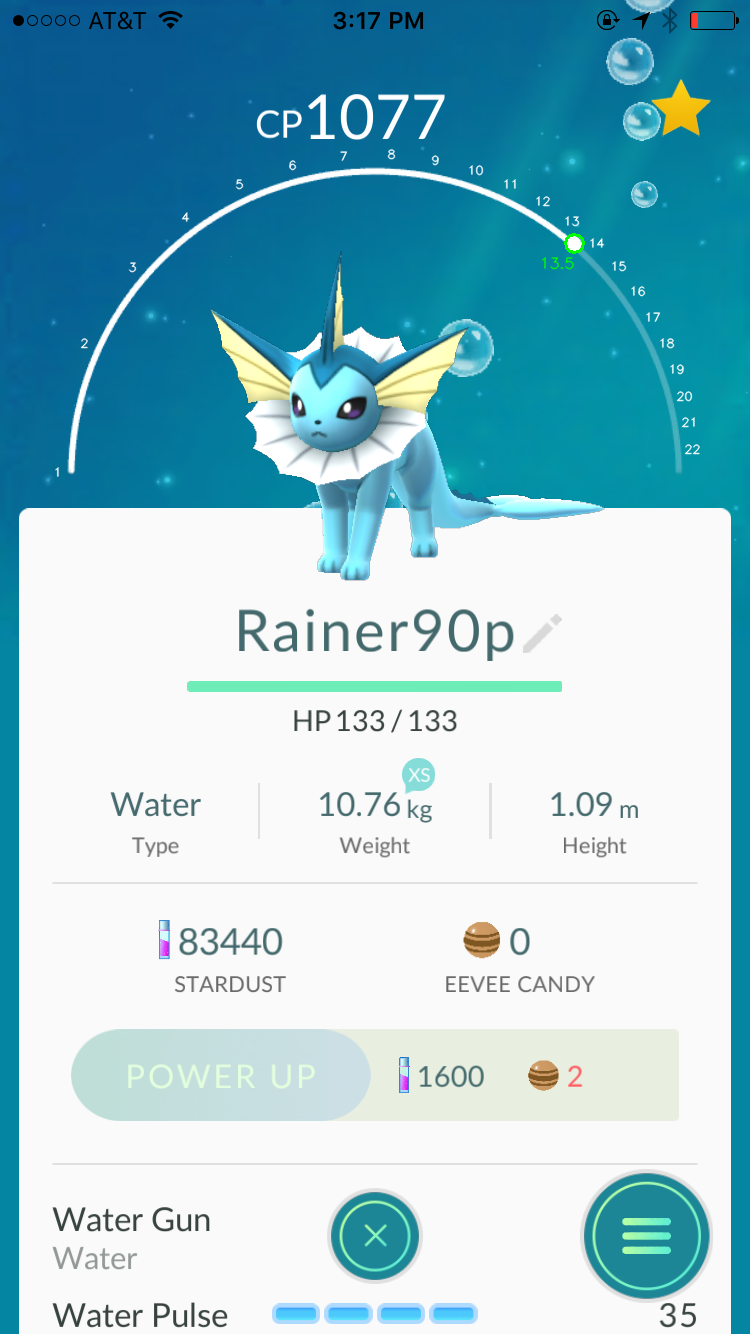

In [9]:
def annotate_level(output, level_index, trainer_level, center, r, r_arcend=9):
    x,y = center
    levels = np.arange(1, trainer_level+2, 0.5)
    r_minor = 2
    r_text, font, f_sz, f_weight = (r + 15, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    r_text_max, f_sz_max = (r - 25, 0.5)

    for i,poke_level in enumerate(levels):
        angle_rad = get_level_pos(poke_level, trainer_level, pokemon_data.cpm_inter)
        xl, yl = angle_to_xy(angle_rad, (x,y), r)
        level_text = "%d" % poke_level if poke_level == int(poke_level) else "%.1f" % poke_level

        if i == level_index:
            pos, baseline = cv2.getTextSize(level_text, font, f_sz_max, f_weight)
            xt, yt = angle_to_xy(angle_rad, (x,y), r_text_max)
            xt -= pos[0]/2
            yt += pos[1]/2
            cv2.putText(output,level_text, (xt,yt), font, f_sz_max, (0,255,0), f_weight, cv2.LINE_AA)
            cv2.circle(output, (xl,yl), r_arcend, (0, 255, 0), 2)
        else:
            if i % 2 == 0:
                pos, baseline = cv2.getTextSize("%d" % poke_level, font, f_sz, f_weight)
                xt, yt = angle_to_xy(angle_rad, (x,y), r_text)
                xt -= pos[0]/2
                yt += pos[1]/2
                cv2.putText(output,"%d" % poke_level, (xt,yt), font, f_sz, (255,255,255), f_weight, cv2.LINE_AA)
                #cv2.circle(output, (xl,yl), r_arcend, (0, 0, 255), 1)
            else:
                #cv2.circle(output, (xl,yl), r_minor, (0, 0, 255), -1)
                pass
    
annotate_level(output, level_index, trainer_level, (x,y), r)
display_cv(output, width=300)